In [1]:
%%capture

!pip install unsloth
!pip install vllm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.1/376.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.7/290.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/17

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys

sys.path.append('/content/drive/MyDrive/dev-files')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%capture

import re
import itertools
import math
import time
import random
from collections import Counter
from pprint import pprint
import json

import numpy as np
import pandas as pd
from numpy.random import choice, randint
from IPython.display import HTML, display, clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Utilities for plotting
from symbolic_utilities import progress, compute_global_limits_smc, plot_mh_trace_upto, plot_state_2d
# MHMC sampler
from symbolic_utilities import propose_tree, get_coordinates, \
    mh_sampler, smc_sampler, define_bs_DSL, define_lt_DSL, enumerate_full_sentences

from neural_utilities import extract_xml_answer, extract_xml_reasoning, produce_tasks, get_data

from neural_utilities import print_func, lt_correctness_reward_func, \
    xmlcount_reward_func, soft_format_reward_func, strict_format_reward_func, cfg_reward_func, lt_correctness_reward_func, \
    direct_cfg_reward_func, direct_lt_correctness_reward_func, direct_conciseness_reward_func

from symbolic_utilities import \
    ltgrammar, lt_nonterminals, lt_terminals, lt_eval_dict, \
    bsgrammar, bs_nonterminals, bs_terminals, bs_eval_dict

# NOTE: PatchFastRL needs to run **before** the imports below
from unsloth import FastLanguageModel, is_bfloat16_supported, PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)

import torch, gc
from torch import tensor
from datasets import load_dataset, Dataset, DatasetDict
from transformers import EarlyStoppingCallback, TextStreamer, TrainingArguments
from peft import AutoPeftModelForCausalLM
from trl import SFTTrainer, GRPOConfig, GRPOTrainer, SFTConfig
from unsloth.chat_templates import get_chat_template
from vllm import SamplingParams

from dotenv import load_dotenv, find_dotenv
import os
from openai import OpenAI
from tqdm import tqdm

print(torch.cuda.get_device_name(0))

In [4]:
def check_accuracy(x, indices, functions):
    function = functions[indices]
    accuracy = 0
    for inp, out in x['examples']:
        if out == function(inp):
            accuracy += 1/len(x['examples'])
    return {'accuracy': accuracy}

max_seq_length = 1024 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

lt_system_prompt = ""

# get all sentences up to depth 5
sentences_pool = []
for i, sent in enumerate(enumerate_full_sentences('T', ltgrammar, max_depth=6)):
    sentences_pool.append(sent)
    if i==500000:
        break

print(sentences_pool[:5])

data = get_data(
    ltgrammar,
    lt_system_prompt,
    eval_dict=lt_eval_dict,
    n_tasks=100000,
    sentences_pool=sentences_pool
)

# the 'sentence' is what we want the model to output for a given input.
data = data.map(lambda x: {
    'completion': [{'content': x['sentence'], 'role': 'assistant'}],
})

# 90% train, 10% test + validation
train_testvalid = data.train_test_split(train_size=2**16, test_size=2* 2**7)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
data = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

data

['reverse', 'sort', 'map_(plus(1))', 'map_(plus(2))', 'map_(plus(3))']


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'examples', 'task', 'prompt', 'completion'],
        num_rows: 65536
    })
    test: Dataset({
        features: ['sentence', 'examples', 'task', 'prompt', 'completion'],
        num_rows: 128
    })
    valid: Dataset({
        features: ['sentence', 'examples', 'task', 'prompt', 'completion'],
        num_rows: 128
    })
})

sentence: target program\
e.g. filter_(and_(or_(gt(2),gt(2)),or_(even,even)))

examples:
[[[5, 5, 8], [8]], [[3, 4], [4]], ...] - shows input and output pairs

task:
human-readable version of the examples which could be directly fed into the prompt

prompt:
the prompt containing `task` in a LLM friendly manner

completions: the sentence according to the task

In [ ]:
d = data['train'][0]['prompt']
# data['train'][0]['completion']

In [ ]:
c = Counter()
for s in data['train']['sentence']:
   c.update({k:s.count(k) for k in lt_terminals})

c

Counter({'even': 164544,
         'reverse': 8379,
         'gt': 140390,
         '3': 36276,
         'compose': 57213,
         'sort': 8153,
         '2': 36384,
         'filter_': 65509,
         'and_': 120178,
         '5': 35841,
         'times': 3,
         ')': 618198,
         '(': 618198,
         ',': 296638,
         'or_': 119247,
         '4': 36353,
         'map_': 40700,
         'minus': 6,
         'plus': 40691,
         '1': 36244,
         'truncate': 8,
         'not_': 34253})

In [ ]:
data['test'].to_pandas().head()

sentence  \
0  compose(map_(plus(1)),filter_(and_(and_(and_(e...   
1  filter_(and_(and_(gt(1),even),or_(or_(even,eve...   
2  compose(map_(plus(5)),filter_(or_(and_(or_(eve...   
3  compose(map_(plus(4)),filter_(or_(not_(gt(2)),...   
4  filter_(and_(not_(gt(2)),and_(and_(even,even),...   

                                            examples  \
0  [[[6, 4, 3, 2], [4]], [[5, 1], [6]], [[7, 4], ...   
1  [[[3, 1, 0, 6, 0], [6]], [[9, 2, 8], [2, 8]], ...   
2  [[[9, 1, 9, 3], [14, 6, 14, 8]], [[0, 8, 2], [...   
3  [[[4, 1, 1, 5], [8, 5, 5, 9]], [[9, 8, 4, 9], ...   
4  [[[2, 6, 7, 1], []], [[1, 3], []], [[8, 3, 6, ...   

                                                task  \
0  -[np.int64(6), np.int64(4), np.int64(3), np.in...   
1  -[np.int64(3), np.int64(1), np.int64(0), np.in...   
2  -[np.int64(9), np.int64(1), np.int64(9), np.in...   
3  -[np.int64(4), np.int64(1), np.int64(1), np.in...   
4  -[np.int64(2), np.int64(6), np.int64(7), np.in...   

                                              prompt  \
0  [{'content': '', 'role': 'system'}, {'content'...   
1  [{'content': '', 'role': 'system'}, {'content'...   
2  [{'content': '', 'role': 'system'}, {'content'...   
3  [{'content': '', 'role': 'system'}, {'content'...   
4  [{'content': '', 'role': 'system'}, {'content'...   

                                          completion  
0  [{'content': 'compose(map_(plus(1)),filter_(an...  
1  [{'content': 'filter_(and_(and_(gt(1),even),or...  
2  [{'content': 'compose(map_(plus(5)),filter_(or...  
3  [{'content': 'compose(map_(plus(4)),filter_(or...  
4  [{'content': 'filter_(and_(not_(gt(2)),and_(an...

## start building model here

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-0.5B-Instruct",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    # fast_inference=True,
    max_lora_rank=lora_rank,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=lora_rank,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_alpha=lora_rank,
    use_gradient_checkpointing = "unsloth",
    random_state=3407,
)

==((====))==  Unsloth 2025.12.9: Fast Qwen2 patching. Transformers: 4.57.3. vLLM: 0.13.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Unsloth 2025.12.9 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


In [ ]:
inputs = tokenizer.apply_chat_template(
    d,
    add_generation_prompt=True,
    tokenize=True,
    return_tensors="pt",
).to("cuda")

In [ ]:
FastLanguageModel.for_inference(model)
text_streamer = TextStreamer(tokenizer)
_ = model.generate(
    inputs,
    streamer=text_streamer,
    max_new_tokens=512,
)

<|im_start|>system
<|im_end|>
<|im_start|>user
-[np.int64(8), np.int64(4), np.int64(2)] -> [np.int64(4), np.int64(8)]
-[np.int64(3), np.int64(4), np.int64(1), np.int64(4), np.int64(4)] -> [np.int64(3), np.int64(4), np.int64(4), np.int64(4)]
-[np.int64(3), np.int64(5)] -> [np.int64(3), np.int64(5)]
<|im_end|>
<|im_start|>assistant
It looks like you're working with NumPy arrays and encountering some operations involving integer types. Here's a breakdown of the operations:

```python
import numpy as np

# Example 1:
print(np.int64(8, 

KeyboardInterrupt: 

In [ ]:
%%capture
FastLanguageModel.for_training(model)

In [ ]:
# Format function
def format_dataset(examples):
    texts = []
    for prompt_msgs, completion_msgs in zip(examples["prompt"], examples["completion"]):
        # Combine prompt and completion messages
        messages = prompt_msgs + completion_msgs

        # Filter out empty system messages
        messages = [msg for msg in messages if msg["content"].strip()]

        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
        texts.append(text)
    return {"text": texts}

# Apply formatting to create the "text" column
formatted_train = data['train'].map(format_dataset, batched=True, remove_columns=data['train'].column_names)
formatted_test = data['test'].map(format_dataset, batched=True, remove_columns=data['test'].column_names)

Map:   0%|          | 0/65536 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

In [ ]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=formatted_train,
    eval_dataset=formatted_test,
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=SFTConfig(
        learning_rate=3e-5,
        lr_scheduler_type="linear",
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        num_train_epochs=0.4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.05,
        warmup_steps=10,
        output_dir="lt_SFT_noreasoning",
        seed=0,
        save_steps=100,
        fp16_full_eval=True,
        per_device_eval_batch_size=2,
        eval_accumulation_steps=4,
        eval_strategy="steps",
        eval_steps=10,
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/65536 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/128 [00:00<?, ? examples/s]

🦥 Unsloth: Padding-free auto-enabled, enabling faster training.


In [ ]:
trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 65,536 | Num Epochs = 1 | Total steps = 1,639
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 2 x 1) = 16
 "-____-"     Trainable parameters = 35,192,832 of 529,225,600 (6.65% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=1639, training_loss=0.2663719842461568, metrics={'train_runtime': 2498.9099, 'train_samples_per_second': 10.49, 'train_steps_per_second': 0.656, 'total_flos': 1.1832231601326336e+16, 'train_loss': 0.2663719842461568, 'epoch': 0.400146484375})

In [ ]:
trainer.save_model('finetuned_lt')

# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r /content/finetuned_lt/ /content/drive/MyDrive/

In [5]:
%%capture
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/content/drive/MyDrive/dev-files/finetuned_lt", # "finetuned_lt",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    # Enable vLLM fast inference
    # fast_inference = True,
)

In [6]:
tokenizer.padding_side = 'left'

prompts = [
    tokenizer.apply_chat_template(p, add_generation_prompt=True, tokenize=False)
    for p in data['test']['prompt']
]

In [ ]:
%%capture
FastLanguageModel.for_inference(model)

In [26]:
def generate_answers(model, tokenizer, prompts, examples=None, eval_dict=None,
                     batch_size=8, max_new_tokens=128,
                     num_return_sequences=1, do_sample=False, temperature=0.7,
                     return_all=False):

    # Tokenize all prompts individually
    tokenized = []
    for i, prompt in enumerate(prompts):
        ids = tokenizer.apply_chat_template(prompt, add_generation_prompt=True, tokenize=True)
        tokenized.append((i, ids))

    # Sort by length (longest first) to minimize padding
    tokenized.sort(key=lambda x: len(x[1]), reverse=True)

    answers = [None] * len(tokenized)

    # Build generate kwargs
    generate_kwargs = dict(
        pad_token_id=tokenizer.pad_token_id,
        max_new_tokens=max_new_tokens,
        num_return_sequences=num_return_sequences,
        do_sample=do_sample,
    )
    if do_sample:
        generate_kwargs['temperature'] = temperature

    for i in tqdm(range(0, len(tokenized), batch_size)):
        batch_items = tokenized[i:i+batch_size]
        indices = [x[0] for x in batch_items]
        seqs = [x[1] for x in batch_items]

        # Pad manually (left padding)
        max_len = max(len(s) for s in seqs)
        padded = []
        attention_masks = []
        for s in seqs:
            pad_len = max_len - len(s)
            padded.append([tokenizer.pad_token_id] * pad_len + s)
            attention_masks.append([0] * pad_len + [1] * len(s))

        input_ids = tensor(padded, dtype=torch.int64).to('cuda')
        attention_mask = tensor(attention_masks, dtype=torch.int64).to('cuda')

        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            **generate_kwargs,
        )

        # outputs shape: (batch_size * num_return_sequences, seq_len)
        for j, idx in enumerate(indices):
            start = j * num_return_sequences
            end = start + num_return_sequences
            prompt_outputs = outputs[start:end]

            decoded = [
                tokenizer.decode(out[max_len:], skip_special_tokens=True)
                for out in prompt_outputs
            ]

            if num_return_sequences == 1:
                answers[idx] = decoded[0]
            elif return_all:
                answers[idx] = decoded
            else:
                # Select best candidate
                answers[idx] = select_best(decoded, examples[idx], eval_dict)

    return answers


def select_best(candidates, examples, eval_dict):
    """Select the candidate with highest accuracy on the examples."""
    best_answer = candidates[0]  # fallback
    best_score = -1

    for candidate in candidates:
        try:
            func = eval(candidate, eval_dict)
            score = sum(1 for inp, out in examples if func(inp) == out) / len(examples)
            if score > best_score:
                best_score = score
                best_answer = candidate
            if score == 1.0:
                break  # perfect match
        except:
            continue

    return best_answer

In [ ]:
answers = generate_answers(model, tokenizer, data['test']['prompt'])

100%|██████████| 16/16 [00:35<00:00,  2.21s/it]


In [27]:
def get_accuracy(answers):
  def safe_eval(answer, eval_dict):
      try:
          return eval(answer, eval_dict)
      except (SyntaxError, TypeError, NameError):
          return None

  functions = [safe_eval(a, lt_eval_dict) for a in answers]

  # Check how many failed
  invalid_count = sum(1 for f in functions if f is None)
  print(f"Invalid syntax: {invalid_count}/{len(functions)} ({100*invalid_count/len(functions):.1f}%)")

  # Modified check_accuracy to handle None functions
  def check_accuracy(x, indices, functions):
      function = functions[indices]
      if function is None:
          return {'accuracy': 0.0}
      accuracy = 0
      for inp, out in x['examples']:
          try:
              if out == function(inp):
                  accuracy += 1/len(x['examples'])
          except Exception:
              pass  # function crashed on this input
      return {'accuracy': accuracy}

  data['test'] = data['test'].map(check_accuracy, fn_kwargs={'functions': functions}, with_indices=True)
  return np.mean(data['test']['accuracy'])

In [ ]:
get_accuracy(answers)

Invalid syntax: 40/128 (31.2%)


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

np.float64(0.22656249999999997)

## now let's start using RL!

In [9]:
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        # print_func,
        # direct_cfg_reward_func,
        direct_lt_correctness_reward_func,
        # direct_conciseness_reward_func
    ],
    args=GRPOConfig(
        # use vLLM for fast inference! (it raises an error)
        # use_vllm = True,
        learning_rate = 5e-6,
        adam_beta1 = 0.9,
        adam_beta2 = 0.99,
        weight_decay = 0.1,
        warmup_ratio = 0.1,
        lr_scheduler_type = "cosine",
        optim = "adamw_8bit",
        logging_steps = 1,
        bf16 = is_bfloat16_supported(),
        fp16 = not is_bfloat16_supported(),
        per_device_train_batch_size = 1,
        # Increase to 4 for smoother training
        gradient_accumulation_steps = 1,
        # Decrease if out of memory
        num_generations = 8,
        max_prompt_length = 256,
        max_completion_length = 64,
        # Set to 1 for a full training run
        num_train_epochs = 1,
        max_steps = 10000,
        save_steps = 500,
        output_dir="/content/drive/MyDrive/dev-files/grpo_checkpoints",
        max_grad_norm = 0.1,
    ),
    train_dataset=data['train'],
)

Unsloth: We now expect `per_device_train_batch_size` * `gradient_accumulation_steps` * `world_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 8


In [ ]:
trainer.train(
    resume_from_checkpoint=True
)

Prediction:  filter_(and_(and_(even,not_(even)),even))
[7, 3, 1] --> [] vs []
Prediction:  filter_(and_(and_(even,not_(even)),even))
[1, 3, 0, 9, 9] --> [] vs []
Prediction:  filter_(and_(and_(even,not_(even)),even))
[1, 1, 1] --> [] vs []
Prediction:  filter_(and_(and_(even,not_(even)),and_(even,not_(even))))
[7, 3, 1] --> [] vs []
Prediction:  filter_(and_(and_(even,not_(even)),and_(even,not_(even))))
[1, 3, 0, 9, 9] --> [] vs []
Prediction:  filter_(and_(and_(even,not_(even)),and_(even,not_(even))))
[1, 1, 1] --> [] vs []
Prediction:  filter_(and_(and_(even,not_(even)),and_(even,not_(even))))
[7, 3, 1] --> [] vs []
Prediction:  filter_(and_(and_(even,not_(even)),and_(even,not_(even))))
[1, 3, 0, 9, 9] --> [] vs []
Prediction:  filter_(and_(and_(even,not_(even)),and_(even,not_(even))))
[1, 1, 1] --> [] vs []
Prediction:  filter_(and_(and_(even,not_(even)),even))
[7, 3, 1] --> [] vs []
Prediction:  filter_(and_(and_(even,not_(even)),even))
[1, 3, 0, 9, 9] --> [] vs []
Prediction:  fil

Streaming output truncated to the last 5000 lines.
[0, 2, 9, 6, 0] --> [10, 7] vs [10, 7]
Prediction:  compose(map_(plus(1)),filter_(and_(and_(and_(gt(1),gt(3)),gt(3)),gt(1))))
[3, 4] --> [4, 5] vs [4, 5]
Prediction:  compose(map_(plus(1)),filter_(and_(and_(gt(3),gt(1)),and_(gt(2),gt(1)))))
[0, 6] --> [7] vs [7]
Prediction:  compose(map_(plus(1)),filter_(and_(and_(gt(3),gt(1)),and_(gt(2),gt(1)))))
[0, 2, 9, 6, 0] --> [10, 7] vs [10, 7]
Prediction:  compose(map_(plus(1)),filter_(and_(and_(gt(3),gt(1)),and_(gt(2),gt(1)))))
[3, 4] --> [4, 5] vs [4, 5]
Prediction:  compose(map_(plus(4)),filter_(and_(and_(and_(gt(5),gt(3)),gt(4)),and_(gt(1),gt(5)))))
[4, 0, 7, 2, 6] --> [8, 11, 6, 10] vs [8, 11, 6, 10]
Prediction:  compose(map_(plus(4)),filter_(and_(and_(and_(gt(5),gt(3)),gt(4)),and_(gt(1),gt(5)))))
[0, 7] --> [11] vs [11]
Prediction:  compose(map_(plus(4)),filter_(and_(and_(and_(gt(5),gt(3)),gt(4)),and_(gt(1),gt(5)))))
[2, 0] --> [6] vs [6]
Prediction:  compose(map_(plus(4)),filter_(and_(a

<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?


Streaming output truncated to the last 5000 lines.
Prediction:  filter_(and_(and_(gt(2),gt(3)),gt(3)))
[5, 4] --> [5, 4] vs [5, 4]
Prediction:  filter_(and_(and_(gt(2),gt(3)),gt(3)))
[5, 1, 0] --> [5] vs [5]
Prediction:  filter_(and_(and_(gt(2),gt(3)),gt(3)))
[1, 0, 8, 6] --> [8, 6] vs [8, 6]
Prediction:  filter_(or_(and_(and_(gt(1),gt(3)),gt(2)),gt(3)))
[5, 4] --> [5, 4] vs [5, 4]
Prediction:  filter_(or_(and_(and_(gt(1),gt(3)),gt(2)),gt(3)))
[5, 1, 0] --> [5] vs [5]
Prediction:  filter_(or_(and_(and_(gt(1),gt(3)),gt(2)),gt(3)))
[1, 0, 8, 6] --> [8, 6] vs [8, 6]
Prediction:  filter_(and_(and_(gt(3),gt(2)),and_(gt(1),gt(3))))
[5, 4] --> [5, 4] vs [5, 4]
Prediction:  filter_(and_(and_(gt(3),gt(2)),and_(gt(1),gt(3))))
[5, 1, 0] --> [5] vs [5]
Prediction:  filter_(and_(and_(gt(3),gt(2)),and_(gt(1),gt(3))))
[1, 0, 8, 6] --> [8, 6] vs [8, 6]
Prediction:  filter_(and_(and_(gt(1),gt(3)),gt(3)))
[5, 4] --> [5, 4] vs [5, 4]
Prediction:  filter_(and_(and_(gt(1),gt(3)),gt(3)))
[5, 1, 0] --> [5] v

In [12]:
trainer.save_model('rl_finetuned')

# !cp -r /content/rl_finetuned/ /content/drive/MyDrive/dev-files

In [13]:
df_history = pd.DataFrame(trainer.state.log_history)

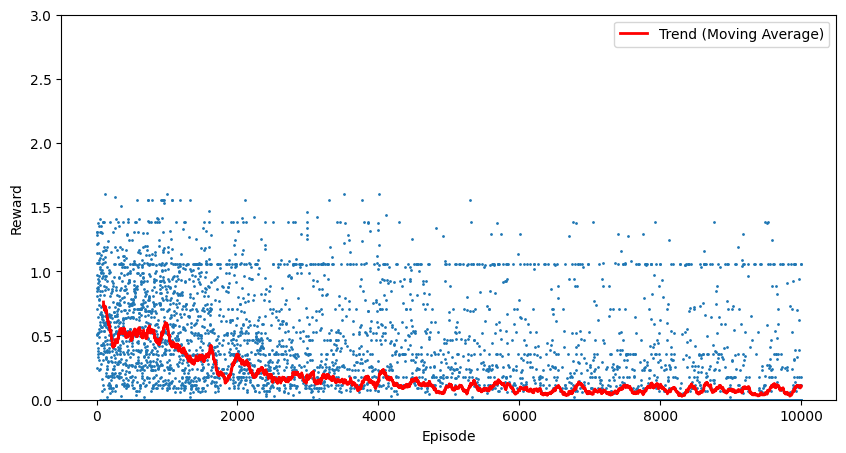

In [23]:
smoothed_rewards = df_history['reward_std'].rolling(window=100).mean()

# Plotting the raw reward and the trend (smoothed reward)
plt.figure(figsize=(10, 5))
plt.plot(df_history.index, smoothed_rewards, label="Trend (Moving Average)", color="red", linewidth=2)
plt.scatter(df_history.index, df_history['reward_std'], s=1)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.ylim(0,3)
plt.legend()
plt.show()

In [24]:
%%capture
model.for_inference()

In [28]:
answers = generate_answers(model, tokenizer, data['test']['prompt'])

100%|██████████| 16/16 [00:39<00:00,  2.45s/it]


In [29]:
get_accuracy(answers)

Invalid syntax: 42/128 (32.8%)


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

np.float64(0.5703125)

Let's sample more sentences now!

In [30]:
answers = generate_answers(
    model, tokenizer,
    data['test']['prompt'],
    examples=data['test']['examples'],  # pass the I/O examples
    eval_dict=lt_eval_dict,
    batch_size=4,
    num_return_sequences=32,
    do_sample=True,
    temperature=0.7
)

100%|██████████| 32/32 [02:00<00:00,  3.77s/it]


In [31]:
get_accuracy(answers)

Invalid syntax: 14/128 (10.9%)


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

np.float64(0.7838541666666667)